In [38]:
%matplotlib notebook

In [39]:
######################################
#00   I/O and Table Join             #
#   a- import code.                  #
#   b- read input files and merge.   # 
#   c- display head of merged df.    #
######################################

#a
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import warnings; warnings.simplefilter('ignore')

#b
codes_dtypes ="data/MRTS_Dtypes.csv"
codes_months ="data/MRTS_months.csv"
codes_cats ="data/MRTS_cats.csv"
codes_geo ="data/MRTS_geo.csv"
codes_err ="data/MRTS_errors.csv"
data_in = "data/MRTS_data.csv"

geo_df = pd.read_csv(codes_geo)
err_df = pd.read_csv(codes_err)
data_df = pd.read_csv(data_in)
cats_df = pd.read_csv(codes_cats)
months_df = pd.read_csv(codes_months)
dtypes_df = pd.read_csv(dtypes_months)


study_data_complete = pd.merge(mouse_metadata,study_results, how="outer", on=["Mouse ID"])

#C
study_data_complete.head(5)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [40]:
###############################################################################
#01         Remove Duplicates                                                 #
#  a- concatenate mouseid and timepoint into mouse_time to check if unique.   #
#  b- look for duplicate mouse_times, create list of any found.               #
#  c- if any duplicates found                                                 #
#     - strip off time and get unique list of mice with duplicate records.    #
#     - create df of records to be removed and print.                         #
#     - delete all records for any mice who had duplicates from complete      #
#       file and mouse file(also used in later sections).                     #
###############################################################################

#a
study_data_complete["mouse_time"] = study_data_complete["Mouse ID"] + study_data_complete["Timepoint"].astype(str)
study_data_complete.sort_values("mouse_time")

#b
duplicates = []
for x in range(len(study_data_complete)-1):  # -1 to avoid key error for trying to read past eodf
    if study_data_complete["mouse_time"][x] == study_data_complete["mouse_time"][(x+1)]:
        duplicates.append(study_data_complete["mouse_time"][x])

#c
if len(duplicates) > 0:
    duplicates2=pd.Series(duplicates)
    duplicates3 = duplicates2.str.slice(stop=4).unique()

    for x in range(len(duplicates3)):
        study_data_removed = study_data_complete[study_data_complete['Mouse ID'] == duplicates3[x]]
        study_data_removed.reset_index(inplace=True, drop=True)
    print(study_data_removed)

    for x in range(len(duplicates3)):
        indexes = study_data_complete[study_data_complete['Mouse ID'] == duplicates3[x]].index
    study_data_complete.drop(indexes, inplace=True)  
    
    for x in range(len(duplicates3)):
        indexes = mouse_metadata[mouse_metadata['Mouse ID'] == duplicates3[x]].index
    mouse_metadata.drop(indexes, inplace=True) 

   Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
0      g989     Propriva  Female          21          26          0   
1      g989     Propriva  Female          21          26          0   
2      g989     Propriva  Female          21          26          5   
3      g989     Propriva  Female          21          26          5   
4      g989     Propriva  Female          21          26         10   
5      g989     Propriva  Female          21          26         10   
6      g989     Propriva  Female          21          26         15   
7      g989     Propriva  Female          21          26         15   
8      g989     Propriva  Female          21          26         20   
9      g989     Propriva  Female          21          26         20   
10     g989     Propriva  Female          21          26         25   
11     g989     Propriva  Female          21          26         30   
12     g989     Propriva  Female          21          26         35   

    T

## Summary Statistics

In [41]:
####   note - assignment called to provide summary by drug, which is what i produced.
####          however, i have left commented code to also group by timepoint, 
####          as this seems likely pertinent to any concern for comparison.
####################################################
#02   Generate Summary                             #
#  a- group data by drug (and timepoint).          #
#  b- gather statistics individually, create df.   #
#  c- display summary df.                          #
####################################################

#a
drug_grp = study_data_complete.groupby("Drug Regimen")
#drug_grp = study_data_complete.groupby(["Drug Regimen", "Timepoint"])

#b
drug_grp_tumor_mean = drug_grp["Tumor Volume (mm3)"].mean()
drug_grp_tumor_medn = drug_grp["Tumor Volume (mm3)"].median()
drug_grp_tumor_var = drug_grp["Tumor Volume (mm3)"].var()
drug_grp_tumor_std = drug_grp["Tumor Volume (mm3)"].std()
drug_grp_tumor_sem = drug_grp["Tumor Volume (mm3)"].sem()
drug_grp_stats = pd.DataFrame({"Mean": drug_grp_tumor_mean, "Median": drug_grp_tumor_medn,
                               "Variance": drug_grp_tumor_var, "STD": drug_grp_tumor_std, "SEM": drug_grp_tumor_sem})
#c
drug_grp_stats

,Mean,Median,Variance,STD,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [42]:
#####   note - (as above, in section 02)
################################################################
#03   Generate Summary2                                        #
#  a- create df while grouping data by drug (and timepoint).   #
#  b- display summary df.                                      #
################################################################

#a
drug_grp_stats2 = study_data_complete.groupby('Drug Regimen').agg(
#drug_grp_stats2 = study_data_complete.groupby(['Drug Regimen', "Timepoint"]).agg(
        Tumor_Vol_Mean=('Tumor Volume (mm3)', np.mean),
        Tumor_Vol_Median=('Tumor Volume (mm3)', np.median),
        Tumor_Vol_Var=('Tumor Volume (mm3)', np.var),
        Tumor_Vol_Stdev=('Tumor Volume (mm3)', np.std),
        Tumor_Vol_SEM=('Tumor Volume (mm3)', st.sem))
#b
drug_grp_stats2

,Tumor_Vol_Mean,Tumor_Vol_Median,Tumor_Vol_Var,Tumor_Vol_Stdev,Tumor_Vol_SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

<IPython.core.display.Javascript object>


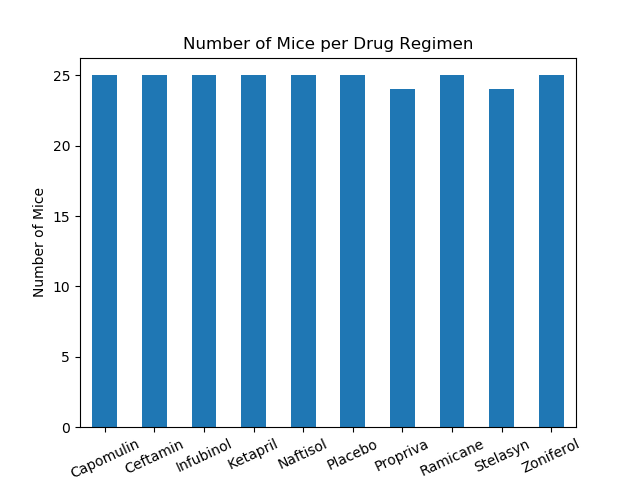

In [43]:
#################################################
#04     Pandas Bar Graph                        #
#  a- group data by drug type and count mice.   #
#  b- create bar graph,add titles and labels.   #
#################################################

#a
drug_mouse_df = mouse_metadata.groupby("Drug Regimen")["Mouse ID"].count()

#b
drug_mouse_df.plot(kind="bar")
plt.title("Number of Mice per Drug Regimen")
plt.ylabel("Number of Mice")
plt.xticks(rotation=25)
plt.show()

<IPython.core.display.Javascript object>


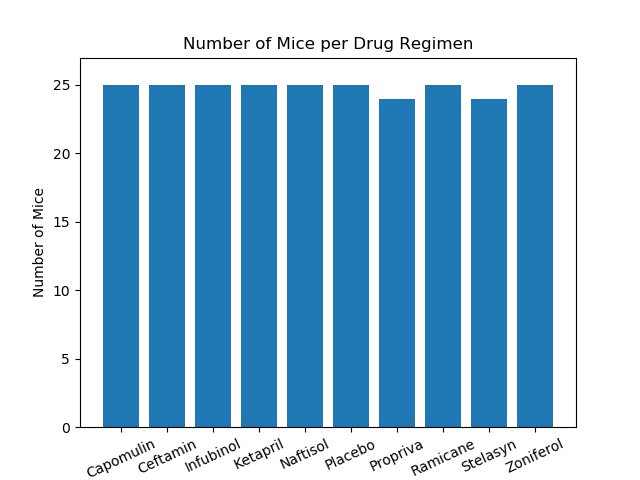

In [44]:
##########################################################
#05    Matplot Bar Graph                                 #
#  a- group data by drug type, create lists for graph.   #
#  b- create bar graph, add title and labels.            #
##########################################################

#a
drug_grp2 = mouse_metadata.groupby("Drug Regimen")
drug_grp2_mice = drug_grp2["Mouse ID"].count()
drug_grp2_drugs = [drug[0] for drug in drug_grp2["Drug Regimen"].unique()]

#b
plt.figure()
plt.bar(drug_grp2_drugs, drug_grp2_mice)
plt.title("Number of Mice per Drug Regimen")
plt.ylabel("Number of Mice")
plt.xticks(drug_grp2_drugs, rotation=25)
plt.ylim(0, max(drug_grp2_mice)+2)
plt.show()

<IPython.core.display.Javascript object>


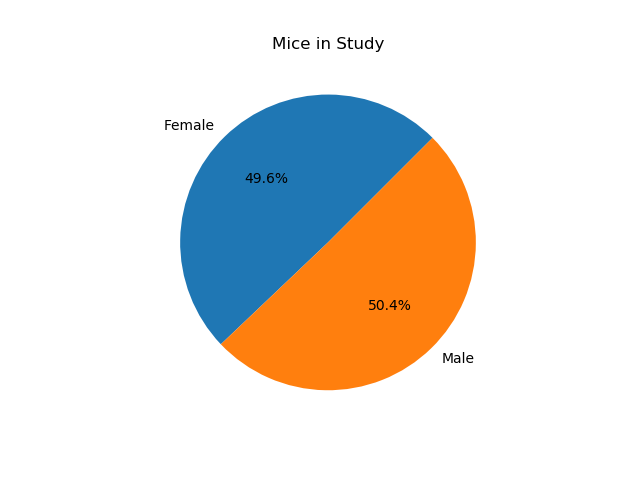

In [45]:
#############################################
#06     Pandas Pie Chart                    #
#  a- group data by sex and count mice      #
#  b- pie chart showing male/female mice.   #
#############################################

#a
sex_df = mouse_metadata.groupby("Sex")["Mouse ID"].count()

#b
plt.figure()
sex_pie = sex_df.plot(kind="pie",y="sex",startangle=45,autopct="%1.1f%%")
sex_pie.set_ylabel("")
plt.title("Mice in Study")
plt.show()

<IPython.core.display.Javascript object>


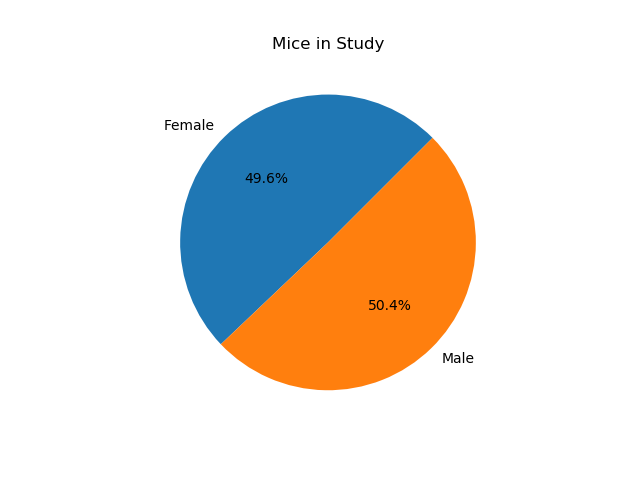

In [46]:
###############################################################
#07     Matlab Pie Chart                                      #
#  a- group data by sex, create variables with mouse count.   #
#  b- pie chart showing male/female mice.                     #
###############################################################

#a
female_df = mouse_metadata.loc[mouse_metadata["Sex"] == "Female"]
female_ct = len(female_df)
male_df = mouse_metadata.loc[mouse_metadata["Sex"] == "Male"]
male_ct = len(male_df)

#b
plt.figure()
plt.pie([female_ct, male_ct],startangle=45,autopct="%1.1f%%",labels= ["Female","Male"])
plt.title("Mice in Study")
plt.show()

## Quartiles, Outliers and Boxplots

<IPython.core.display.Javascript object>


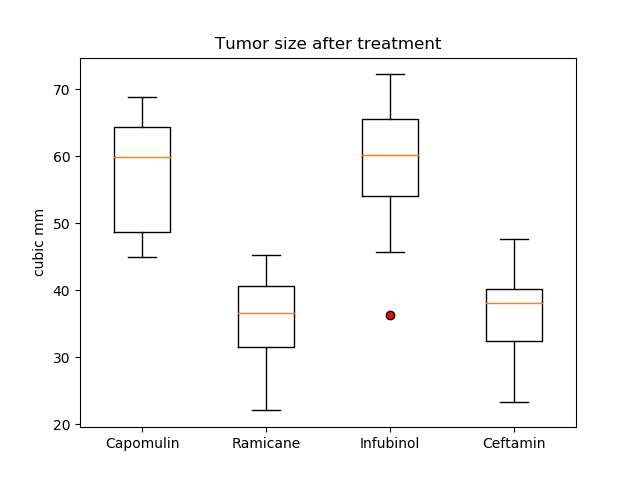

In [47]:
##########################################################################
#08         Boxplot Four Drugs                                           #                             
#  a- create new df with select 4 treatments.                            #
#  b- remove all but latest test record for each mouse.                  #
#  c- create 4 df's, one each for 4 drugs (used also in IQ Summaries).   #
#  d- extract and round tumor size for each drug for boxplot input.      #
#  e- create boxplot showing end tumor size for each drug.               #
##########################################################################

#a
four_drugs_df = study_data_complete[(study_data_complete["Drug Regimen"] == "Capomulin") | 
                                    (study_data_complete["Drug Regimen"] == "Infubinol") |
                                    (study_data_complete["Drug Regimen"] == "Ramicane")  |
                                    (study_data_complete["Drug Regimen"] == "Ceftamin") ] 

#b sort df so each mouse has latest timepoint on top                                 
four_drugs_df.sort_values(["Mouse ID", "Timepoint"], ascending = (True,False),inplace=True)
four_drugs_df.reset_index(inplace = True, drop = True)
mouse_hold = "mouse"
for x in range (len(four_drugs_df)):  
    if four_drugs_df["Mouse ID"][x] != mouse_hold:
        mouse_hold = four_drugs_df["Mouse ID"][x]
    else:
        four_drugs_df.drop(x,inplace=True) 
#c       
capomulin_df = four_drugs_df[(four_drugs_df["Drug Regimen"] == "Capomulin")]
infubinol_df = four_drugs_df[(four_drugs_df["Drug Regimen"] == "Infubinol")]
ramicane_df = four_drugs_df[(four_drugs_df["Drug Regimen"] == "Ramicane")]
ceftamin_df = four_drugs_df[(four_drugs_df["Drug Regimen"] == "Ceftamin")]
capomulin_df.reset_index(inplace = True, drop = True)
infubinol_df.reset_index(inplace = True, drop = True)
ramicane_df.reset_index(inplace = True, drop = True)
ceftamin_df.reset_index(inplace = True, drop = True)

#d
cap_tum = round(capomulin_df["Tumor Volume (mm3)"],2)
inf_tum = round(infubinol_df["Tumor Volume (mm3)"],2)
ram_tum = round(ramicane_df["Tumor Volume (mm3)"],2)
cef_tum = round(ceftamin_df["Tumor Volume (mm3)"],2)

#e
drugs=["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]
outlies = dict(markerfacecolor='r', marker='o')
fig1, ax1 = plt.subplots()
ax1.set_title('Tumor size after treatment')
ax1.set_ylabel('cubic mm')
ax1.set_xticklabels(drugs)
ax1.boxplot([cef_tum,ram_tum,inf_tum,cap_tum],flierprops=outlies)
plt.show()

In [48]:
#####################################################################################
#09        Capomulin IQ Summary                                                     #
#  a- get inner quartile values for tumor sizes and determine outlier boundaries.   #
#  b- print summary.                                                                #
#  c- determine if any outliers, how many, and where: print msg(s) accordingly.     #
#####################################################################################

#a
cap_quart = cap_tum.quantile([.25,.5,.75])
cap_low_quart = cap_quart[0.25]
cap_upp_quart = cap_quart[0.75]
cap_iqr = round((cap_upp_quart - cap_low_quart),2)
cap_low_bound = round((cap_low_quart - (1.5 * cap_iqr)),2)
cap_upp_bound = round((cap_upp_quart + (1.5 * cap_iqr)),2)

#b
print('\033[1m' + "Capomulin Treatment " + '\033[0m' + "- Inner Quartile Summary on Final Tumor Size (in cubic mm's)" )# +"\n")
print(f"  The lower quartile is: {cap_low_quart}")
print(f"  The upper quartile is: {cap_upp_quart}")
print(f"  The interquartile range is: {cap_iqr}")
print(f"  The the median is: {cap_quart[0.5]} ")
print(f"\nValues below {cap_low_bound} or above {cap_upp_bound} could be outliers.")

#c
cap_low_vals = capomulin_df[capomulin_df["Tumor Volume (mm3)"] < cap_low_bound]
cap_upp_vals = capomulin_df[capomulin_df["Tumor Volume (mm3)"] > cap_upp_bound]
cap_lows = len(cap_low_vals)
cap_upps = len(cap_upp_vals)

if (cap_lows + cap_upps) == 0:
    print(f'\033[94m' + "  There are no possible outliers" + '\033[0m')
elif cap_lows > 0:
    if cap_lows == 1:
        print('\033[91m' + "  There is one possible outlier below " + str(cap_low_bound) + '\033[0m')
    else:
        print('\033[91m' + "  There are " + str(len(cap_low_vals)) + " possible outliers below " +str(cap_low_bound) +'\033[0m')
elif cap_upps > 0:
    if cap_upps == 1:
        print('\033[91m' + "  There is one possible outlier above " + str(cap_upp_bound) + '\033[0m')
    else:
        print('\033[91m' + "  There are " + str(len(cap_upp_vals)) + " possible outliers below " +str(cap_upp_bound) +'\033[0m')

Capomulin Treatment - Inner Quartile Summary on Final Tumor Size (in cubic mm's)
  The lower quartile is: 32.38
  The upper quartile is: 40.16
  The interquartile range is: 7.78
  The the median is: 38.13 

Values below 20.71 or above 51.83 could be outliers.
  There are no possible outliers


In [49]:
#####################################################################################
#09        Infubinol IQ Summary                                                     #
#  a- get inner quartile values for tumor sizes and determine outlier boundaries.   #
#  b- print summary.                                                                #
#  c- determine if any outliers, how many, and where: print msg(s) accordingly.     #
#####################################################################################

#a
inf_quart = inf_tum.quantile([.25,.5,.75])
inf_low_quart = inf_quart[0.25]
inf_upp_quart = inf_quart[0.75]
inf_iqr = round((inf_upp_quart - inf_low_quart),2)
inf_low_bound = round((inf_low_quart - (1.5 * inf_iqr)),2)
inf_upp_bound = round((inf_upp_quart + (1.5 * inf_iqr)),2)

#b
print('\033[1m' + "Infubinol Treatment " + '\033[0m' + "- Inner Quartile Summary on Final Tumor Size (in cubic mm's)" )# +"\n")
print(f"  The lower quartile is: {inf_low_quart}")
print(f"  The upper quartile is: {inf_upp_quart}")
print(f"  The interquartile range is: {inf_iqr}")
print(f"  The the median is: {inf_quart[0.5]} ")
print(f"\nValues below {inf_low_bound} or above {inf_upp_bound} could be outliers.")

#c
inf_low_vals = infubinol_df[infubinol_df["Tumor Volume (mm3)"] < inf_low_bound]
inf_upp_vals = infubinol_df[infubinol_df["Tumor Volume (mm3)"] > inf_upp_bound]
inf_lows = len(inf_low_vals)
inf_upps = len(inf_upp_vals)

if (inf_lows + inf_upps) == 0:
    print(f'\033[94m' + "  There are no possible outliers" + '\033[0m')
elif inf_lows > 0:
    if inf_lows == 1:
        print('\033[91m' + "  There is one possible outlier below " + str(inf_low_bound) + '\033[0m')
    else:
        print('\033[91m' + "  There are " + str(len(inf_low_vals)) + " possible outliers below " +str(inf_low_bound) +'\033[0m')
elif inf_upps > 0:
    if inf_upps == 1:
        print('\033[91m' + "  There is one possible outlier above " + str(inf_upp_bound) + '\033[0m')
    else:
        print('\033[91m' + "  There are " + str(len(inf_upp_vals)) + " possible outliers below " +str(inf_upp_bound) +'\033[0m')

Infubinol Treatment - Inner Quartile Summary on Final Tumor Size (in cubic mm's)
  The lower quartile is: 54.05
  The upper quartile is: 65.53
  The interquartile range is: 11.48
  The the median is: 60.17 

Values below 36.83 or above 82.75 could be outliers.
  There is one possible outlier below 36.83


In [50]:
#####################################################################################
#10        Ramicane IQ Summary                                                      #
#  a- get inner quartile values for tumor sizes and determine outlier boundaries.   #
#  b- print summary.                                                                #
#  c- determine if any outliers, how many, and where: print msg(s) accordingly.     #
#####################################################################################

#a
ram_quart = ram_tum.quantile([.25,.5,.75])
ram_low_quart = ram_quart[0.25]
ram_upp_quart = ram_quart[0.75]
ram_iqr = round((ram_upp_quart - ram_low_quart),2)
ram_low_bound = round((ram_low_quart - (1.5 * ram_iqr)),2)
ram_upp_bound = round((ram_upp_quart + (1.5 * ram_iqr)),2)

#b
print('\033[1m' + "Ramicane Treatment " + '\033[0m' + "- Inner Quartile Summary on Final Tumor Size (in cubic mm's)" )# +"\n")
print(f"  The lower quartile is: {ram_low_quart}")
print(f"  The upper quartile is: {ram_upp_quart}")
print(f"  The interquartile range is: {ram_iqr}")
print(f"  The the median is: {ram_quart[0.5]} ")
print(f"\nValues below {ram_low_bound} or above {ram_upp_bound} could be outliers.")

#c
ram_low_vals = ramicane_df[ramicane_df["Tumor Volume (mm3)"] < ram_low_bound]
ram_upp_vals = ramicane_df[ramicane_df["Tumor Volume (mm3)"] > ram_upp_bound]
ram_lows = len(ram_low_vals)
ram_upps = len(ram_upp_vals)

if (ram_lows + ram_upps) == 0:
    print(f'\033[94m' + "  There are no possible outliers" + '\033[0m')
elif ram_lows > 0:
    if ram_lows == 1:
        print('\033[91m' + "  There is one possible outlier below " + str(ram_low_bound) + '\033[0m')
    else:
        print('\033[91m' + "  There are " + str(len(ram_low_vals)) + " possible outliers below " +str(ram_low_bound) +'\033[0m')
elif ram_upps > 0:
    if ram_upps == 1:
        print('\033[91m' + "  There is one possible outlier above " + str(ram_upp_bound) + '\033[0m')
    else:
        print('\033[91m' + "  There are " + str(len(ram_upp_vals)) + " possible outliers below " +str(ram_upp_bound) +'\033[0m')

Ramicane Treatment - Inner Quartile Summary on Final Tumor Size (in cubic mm's)
  The lower quartile is: 31.56
  The upper quartile is: 40.66
  The interquartile range is: 9.1
  The the median is: 36.56 

Values below 17.91 or above 54.31 could be outliers.
  There are no possible outliers


In [51]:
#####################################################################################
#11        Ceftamin IQ Summary                                                      #
#  a- get inner quartile values for tumor sizes and determine outlier boundaries.   #
#  b- print summary.                                                                #
#  c- determine if any outliers, how many, and where: print msg(s) accordingly.     #
#####################################################################################

#a
cef_quart = cef_tum.quantile([.25,.5,.75])
cef_low_quart = cef_quart[0.25]
cef_upp_quart = cef_quart[0.75]
cef_iqr = round((cef_upp_quart - cef_low_quart),2)
cef_low_bound = round((cef_low_quart - (1.5 * cef_iqr)),2)
cef_upp_bound = round((cef_upp_quart + (1.5 * cef_iqr)),2)

#b
print('\033[1m' + "Ceftamin Treatment " + '\033[0m' + "- Inner Quartile Summary on Final Tumor Size (in cubic mm's)" )# +"\n")
print(f"  The lower quartile is: {cef_low_quart}")
print(f"  The upper quartile is: {cef_upp_quart}")
print(f"  The interquartile range is: {cef_iqr}")
print(f"  The the median is: {cef_quart[0.5]} ")
print(f"\nValues below {cef_low_bound} or above {cef_upp_bound} could be outliers.")

#c
cef_low_vals = ceftamin_df[ceftamin_df["Tumor Volume (mm3)"] < cef_low_bound]
cef_upp_vals = ceftamin_df[ceftamin_df["Tumor Volume (mm3)"] > cef_upp_bound]
cef_lows = len(cef_low_vals)
cef_upps = len(cef_upp_vals)

if (cef_lows + cef_upps) == 0:
    print(f'\033[94m' + "  There are no possible outliers" + '\033[0m')
elif cef_lows > 0:
    if cef_lows == 1:
        print('\033[91m' + "  There is one possible outlier below " + str(cef_low_bound) + '\033[0m')
    else:
        print('\033[91m' + "  There are " + str(len(cef_low_vals)) + " possible outliers below " +str(cef_low_bound) +'\033[0m')
elif cef_upps > 0:
    if cef_upps == 1:
        print('\033[91m' + "  There is one possible outlier above " + str(cef_upp_bound) + '\033[0m')
    else:
        print('\033[91m' + "  There are " + str(len(cef_upp_vals)) + " possible outliers below " +str(cef_upp_bound) +'\033[0m')

Ceftamin Treatment - Inner Quartile Summary on Final Tumor Size (in cubic mm's)
  The lower quartile is: 48.72
  The upper quartile is: 64.3
  The interquartile range is: 15.58
  The the median is: 59.85 

Values below 25.35 or above 87.67 could be outliers.
  There are no possible outliers


## Line and Scatter Plots

<IPython.core.display.Javascript object>


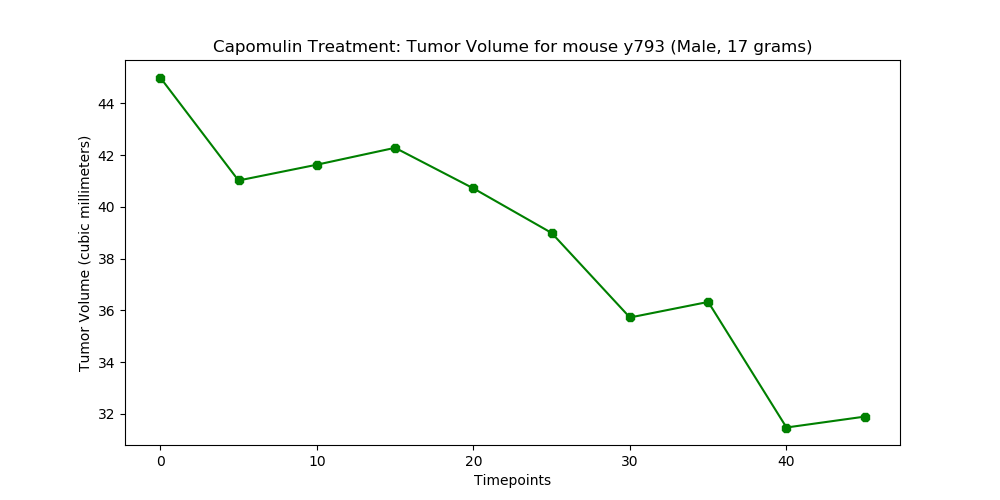

In [52]:
##########         ****   Note   ****                    ########
#####  this code generates a graph for a random mouse        ####
#####  rerunning it will (most likely) generate a new graph  ####
#######################################################################################
#12      LinePlot                                                                     #
#  a- create df of mice who made it to end of study, randomly select one (x).         #
#  b- create x_df with all records for mouse x, extract timepoint and tumor volume.   #
#  c- create line graph of tumor volume over time.                                    #
#######################################################################################

#a
timepoint45_df = capomulin_df[capomulin_df["Timepoint"] == 45]
timepoint45_df.reset_index(drop=True,inplace=True)
x = np.random.randint(len(timepoint45_df))

#b
x_mouseid = timepoint45_df["Mouse ID"][x]
x_df = study_data_complete[study_data_complete["Mouse ID"] == x_mouseid]
x_df.reset_index(drop=True, inplace=True)

x_timepoints = x_df["Timepoint"].tolist()
x_tumorsize = x_df["Tumor Volume (mm3)"].tolist()

#c
plt.figure(figsize=(10,5))
plt.plot(x_timepoints, x_tumorsize, marker="8", color="g")
plt.title("Capomulin Treatment: Tumor Volume for mouse " + x_mouseid + " (" + x_df["Sex"][0] + ", " +
          str(x_df["Weight (g)"][0]) + " grams)")
plt.xlabel("Timepoints")
plt.ylabel("Tumor Volume (cubic millimeters)")
plt.show()

<IPython.core.display.Javascript object>


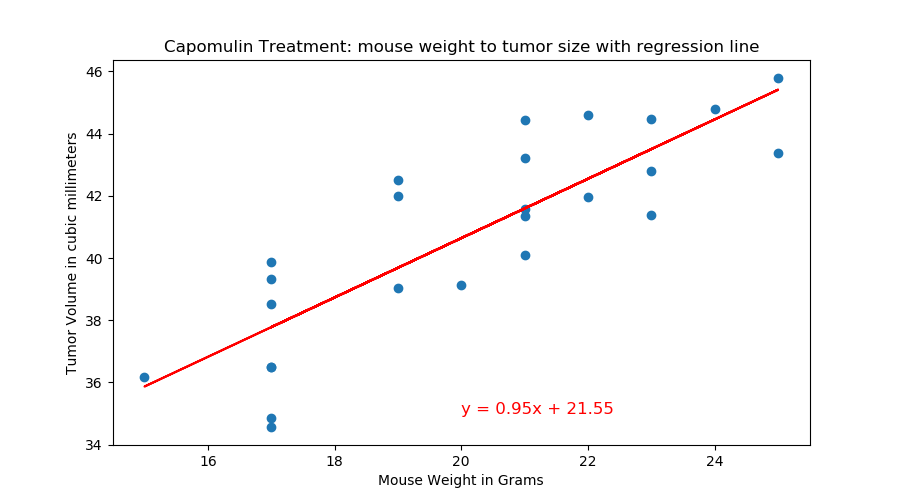

In [53]:
###############################################################
#13      ScatterPlot                                          #
#  a- create cap regimen df from complete, groupby mice,      #
#     extract mouse weight and avg tumor size across study.   #
#  b- scatterplot tumor size against weight                   #
###############################################################

#a
cap_complete = study_data_complete[(study_data_complete["Drug Regimen"] == "Capomulin")]
cap_complete.reset_index(drop=True,inplace=True)
cap_mouse_grp_df = cap_complete.groupby("Mouse ID").mean()
cap_mouse_weight = cap_mouse_grp_df["Weight (g)"]
cap_mouse_tumor = round(cap_mouse_grp_df["Tumor Volume (mm3)"],6)

#b
plt.figure(figsize=(9,5))
plt.scatter(cap_mouse_weight,cap_mouse_tumor)
plt.xlabel("Mouse Weight in Grams")
plt.ylabel("Tumor Volume in cubic millimeters")
plt.title("Capomulin Treatment: mouse weight to tumor size")
plt.show()

## Correlation and Regression

In [54]:
#########################################################################
#14      Linear Regression                                              #
#  a- call linregress with axis values from section 13.                 #
#  b- create regression line and plot onto scatterplot in section 13.   #
#########################################################################

#a
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(cap_mouse_weight,cap_mouse_tumor)

#b
regress_line = slope * cap_mouse_weight + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(cap_mouse_weight, regress_line,"r-")
plt.annotate(line_eq,(20,35),fontsize=12,color="r")
plt.title("Capomulin Treatment: mouse weight to tumor size with regression line")
plt.show()